In [72]:
import geopandas as gp
import requests

In [74]:
tiles = gp.read_file("sentinel2_tiles.geojson")
target = gp.read_file("Kharkiv_region.geojson")

In [75]:
target

,geometry
0,"POLYGON ((35.46387 50.43652, 34.66187 50.02892..."


### Plot target polygon

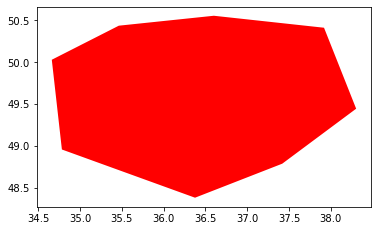

In [76]:
ax = target.plot(color='red')

### Build R-tree to find tiles, using spatial index based on [tutorial](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html)

In [77]:
# spatial index for intersection points
intersection_sindex = tiles.sindex

In [78]:
# How many groups do we have?
print("Number of groups:", len(intersection_sindex.leaves()))

Number of groups: 810


In [79]:
# Get the indices of the tiles that are likely to be inside the bounding box of the given Polygon
# and get tiles
tiles_indexes = list(intersection_sindex.intersection(target.geometry[0].bounds))
tiles = tiles.loc[tiles_indexes]
tiles.tail()

,Name,description,tessellate,extrude,visibility,snippet,geometry
34028,36UXB,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((34.43888 51.44235 0.00000, 36.0170..."
34923,37UCS,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((36.12371 51.41588 0.00000, 37.7020..."
34932,37UDS,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((37.56055 51.44235 0.00000, 39.1404..."
34041,36UYU,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((35.71882 48.72093 0.00000, 37.2082..."
34034,36UXU,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((34.36028 48.74498 0.00000, 35.8524..."


#### Plot basic tiles

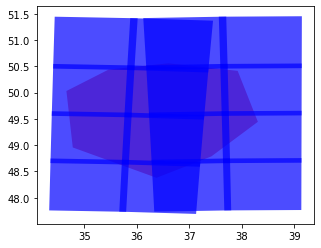

In [80]:
ax = target.plot(color='red', alpha=0.5)
ax = tiles.plot(ax=ax, color='blue', markersize=2, alpha=0.7)

In [81]:
# Make the precise tiles in Polygon query
tiles = tiles.loc[tiles.intersects(target.geometry[0])]

In [82]:
tiles.tail()

,Name,description,tessellate,extrude,visibility,snippet,geometry
34037,36UYB,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((35.87572 51.41590 0.00000, 37.4505..."
34028,36UXB,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((34.43888 51.44235 0.00000, 36.0170..."
34923,37UCS,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((36.12371 51.41588 0.00000, 37.7020..."
34041,36UYU,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((35.71882 48.72093 0.00000, 37.2082..."
34034,36UXU,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((34.36028 48.74498 0.00000, 35.8524..."


#### Plot tiles after precising

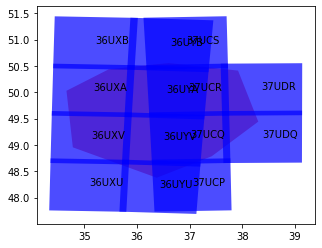

In [83]:
ax = target.plot(color='red', alpha=0.5)
ax = tiles.plot(ax=ax, color='blue', markersize=2, alpha=0.7)
_ = tiles.apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0]), axis=1)

#### Loc tiles with area $$S \geq 1000 m^2 \, or \, 0.001 km^2$$

#### Check coordinate system [epsg:4326](https://epsg.io/4326) with **unit:degrees**, so we need to change it to [epsg:6933](https://epsg.io/6933) with **units:meters** 

In [84]:
tiles.crs

{'init': 'epsg:4326'}

In [85]:
# change geometry and calculate intersection area
target['geometry'] = target.geometry.to_crs({'init': 'epsg:6933'})

In [86]:
target

,geometry
0,"POLYGON ((3421776.628 5649966.097, 3344394.443..."


In [87]:
tiles.tail()

,Name,description,tessellate,extrude,visibility,snippet,geometry
34037,36UYB,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((35.87572 51.41590 0.00000, 37.4505..."
34028,36UXB,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((34.43888 51.44235 0.00000, 36.0170..."
34923,37UCS,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((36.12371 51.41588 0.00000, 37.7020..."
34041,36UYU,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((35.71882 48.72093 0.00000, 37.2082..."
34034,36UXU,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((34.36028 48.74498 0.00000, 35.8524..."


In [88]:
tiles['geometry'] = tiles.geometry.to_crs({'init': 'epsg:6933'})
tiles['area'] = tiles.geometry.apply(lambda g: g.intersection(target.geometry[0]).area / 1e6)
tiles = tiles.loc[tiles['area'] > 0.001]

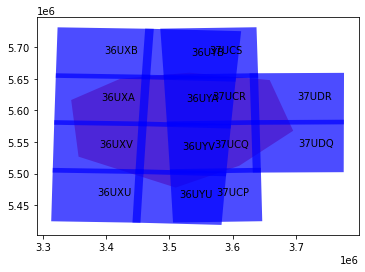

In [89]:
ax = target.plot(color='red', alpha=0.5)
ax = tiles.plot(ax=ax, color='blue', markersize=2, alpha=0.7)
_ = tiles.apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0]), axis=1)

#### Let's fill target polygon with tiles one by one based on biggest area and smaller name

In [90]:
tiles = tiles.sort_values(by=['area', 'Name'], ascending=[False, True])

In [91]:
tiles.head()

,Name,description,tessellate,extrude,visibility,snippet,geometry,area
34036,36UYA,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((3456212.751 5656643.742 0.000, 360...",11989.221268
34042,36UYV,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((3451170.944 5582487.885 0.000, 359...",11921.593870
34922,37UCR,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((3490745.053 5656642.624 0.000, 364...",11661.453416
34921,37UCQ,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((3495787.865 5582486.782 0.000, 364...",11122.932472
34035,36UXV,TILE PROPERTIES<br><table border=0 cellpadding...,-1,0,-1,,"POLYGON Z ((3317697.509 5584555.305 0.000, 346...",7869.233590


In [92]:
t = target.copy()

In [93]:
%%time
result_tiles = list()
for row in tiles.itertuples():
    start_area = t.geometry[0].area
    t.geometry[0] = t.geometry[0].difference(row.geometry)
    if start_area != t.geometry[0].area:
        result_tiles.append(dict(Name=row.Name, geometry=row.geometry))

Wall time: 9.97 ms


In [94]:
tiles_df = gp.GeoDataFrame(result_tiles, crs={'init' :'epsg:6933'})
tiles_df = tiles_df.to_crs({'init':'epsg:4326'})

#### Final plot

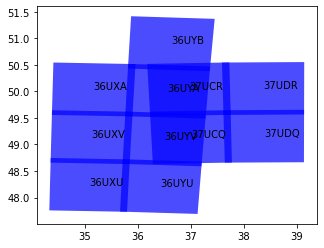

In [95]:
ax = tiles_df.plot(color='blue', markersize=2, alpha=0.7)
_ = tiles_df.apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0]), axis=1)

#### Save to file

In [96]:
path = "overlap.geojson"

In [97]:
tiles_df.to_file(path, driver='GeoJSON')

### Final tiles Names

In [99]:
print(sorted(list(tiles_df.Name)))

['36UXA', '36UXU', '36UXV', '36UYA', '36UYB', '36UYU', '36UYV', '37UCQ', '37UCR', '37UDQ', '37UDR']
